# Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.compose import ColumnTransformer, make_column_selector

pd.options.mode.copy_on_write = True

sns.set_theme()

In [2]:
dataset = pd.read_csv('./data/cluster_dataset.csv')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   borough                       742 non-null    float64
 1   location_category             742 non-null    float64
 2   development_type              742 non-null    float64
 3   month_service_start_date_sin  742 non-null    float64
 4   month_service_start_date_cos  742 non-null    float64
 5   day_service_start_date_sin    742 non-null    float64
 6   day_service_start_date_cos    742 non-null    float64
 7   month_service_end_date_sin    742 non-null    float64
 8   month_service_end_date_cos    742 non-null    float64
 9   day_service_end_date_sin      742 non-null    float64
 10  day_service_end_date_cos      742 non-null    float64
 11  is_only_water_sewer_charges   742 non-null    bool   
 12  year_service_start_date       742 non-null    int64  
 13  year_

Define the normalizer. Since outlier will not be eliminated a RobustScaler is preferred.

In [4]:
normalization = ColumnTransformer(
    transformers=[
        ('robust', RobustScaler(), ['consumption_(hcf)', 'current_charges', 'bill_analyzed_score', 'estimated_score']),
        ('minmax_date', MinMaxScaler((0, 1)), make_column_selector(pattern=r'^month|^year|^day')),
    ], 
    remainder='passthrough').set_output(transform='pandas')

Define the pipelines that will be used.

In [5]:
pipe_pca_norm = Pipeline([
    ('norm', normalization),
    ('pca', PCA(n_components=2, random_state=42)),
])

pipe_kpca_norm = Pipeline([
    ('norm', normalization),
    ('pca', KernelPCA(random_state=42, n_components=2, kernel='rbf')),
])

pipe_3kpca_norm = Pipeline([
    ('norm', normalization),
    ('pca', KernelPCA(random_state=42, n_components=3, kernel='rbf')),
])

It is possible to see how the firtst two PC explains most of the variance.

In [6]:
pipe_pca_norm.fit(dataset)[-1].explained_variance_ratio_.cumsum()

array([0.99998724, 0.99999578])

Let's store the two pre processed datasets:

In [7]:
pre_processed_dataset_no_dim = normalization.fit_transform(dataset)
pre_processed_dataset_pca = pipe_pca_norm.fit_transform(dataset)
pre_processed_dataset_kpca = pipe_kpca_norm.fit_transform(dataset)
pre_processed_dataset_3kpca = pipe_3kpca_norm.fit_transform(dataset)

Here there are two function to help plotting during the analysis. The first one returns a silhoutte plot.

In [8]:
def plot_silhoutte(pre_processed_dataset, labels, n_clusters, ax):
    silhouette_vals = silhouette_samples(pre_processed_dataset, labels)
    avg_silhouette = silhouette_score(pre_processed_dataset, labels)

    y_lower = 10

    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()

        # Define the range for the cluster
        y_upper = y_lower + len(cluster_silhouette_vals)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0, cluster_silhouette_vals,
            alpha=0.7
        )
        ax.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), str(i))
        y_lower = y_upper + 10  # Add space between clusters

    ax.axvline(avg_silhouette, color="red", linestyle="--")
    ax.set_xlabel(f"Silhouette coefficient {round(avg_silhouette, 2)}")
    ax.set_ylabel("Cluster label")
    ax.set_title(f"K = {n_clusters}")

    plt.tight_layout()

    return avg_silhouette

The second one returns a subplot with the results of clustering in 2D.

In [9]:
def vis_clusters(labels_lst, data_reduces, score, n_rows=3, n_cols=2, eps=[]):
    # Note eps if present should have the same size of 3 x 2, or errors will be raised
    _, axes = plt.subplots(n_rows, n_cols, figsize=(16, 9))

    flat_cond = n_rows > 1 and n_cols > 1

    axes = axes.flatten() if flat_cond else axes

    for i, labels in enumerate(labels_lst):

        if len(eps) != 0:
            titles_eps = f'eps = {eps[i]} - Silhouette: {score[i]}'
        else: 
            title_classic = f'K = {i + 2} - Silhouette: {score[i]}'

        ax = sns.scatterplot(
                x=data_reduces[:, 0], 
                y=data_reduces[:, 1], 
                hue=labels,
                palette='deep',
                ax=axes[i] if flat_cond else axes
            ).set_title(title_classic if len(eps) == 0 else titles_eps).axes;

        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        plt.tight_layout()

## K-Means without dimensionality reduction

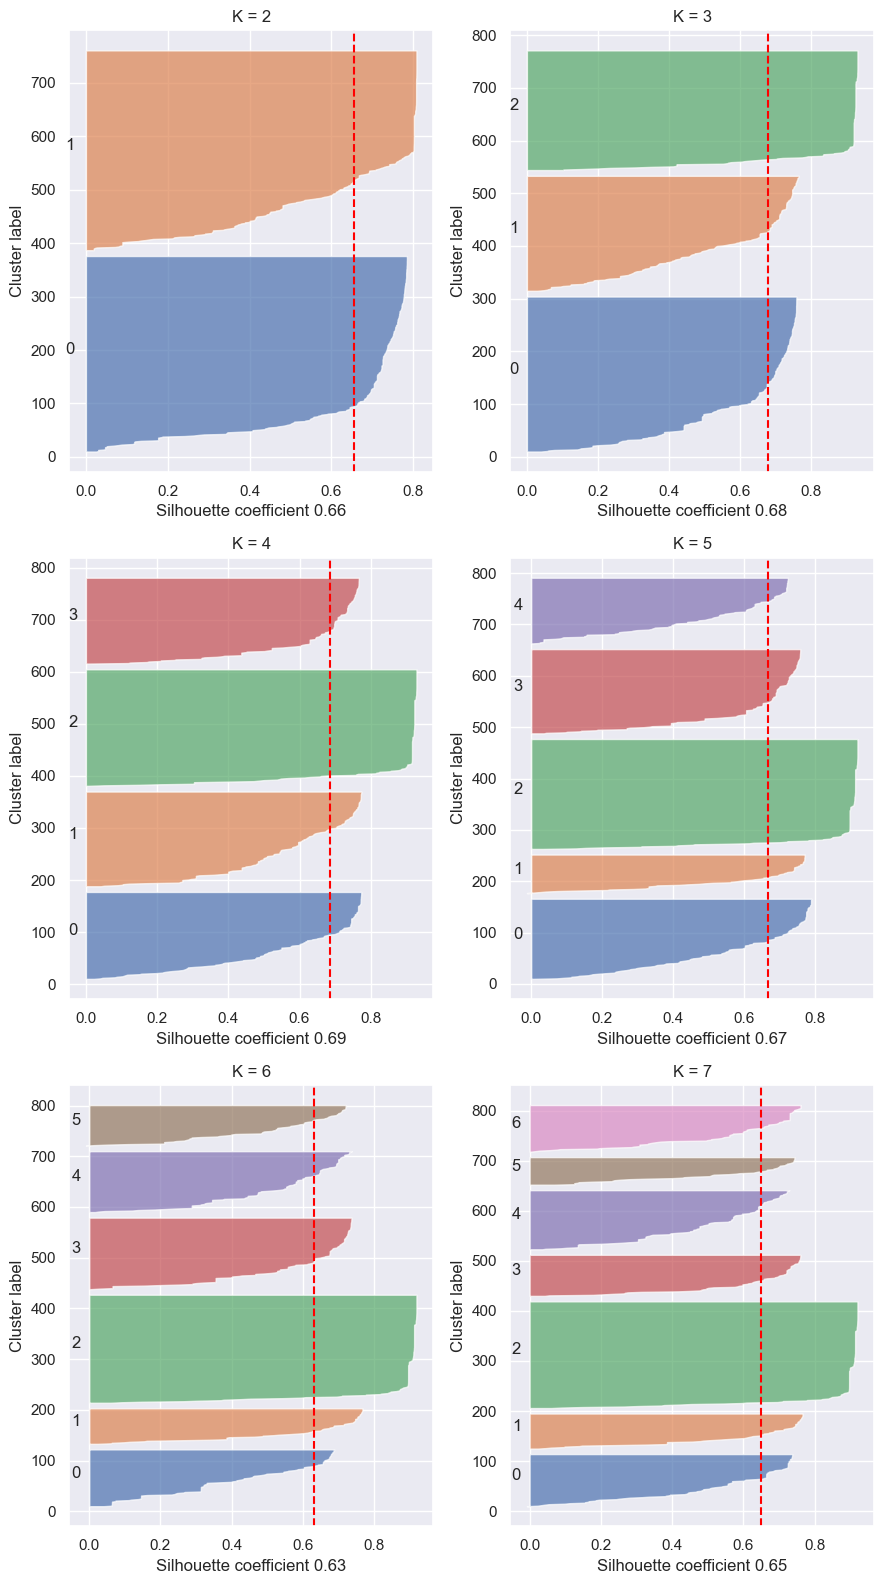

In [10]:
n_clusters_max = 8
fig, ax = plt.subplots(3, 2, figsize=(9, 16))

ax = ax.flatten()

for n_clusters in range(2, n_clusters_max):
    labels = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(pre_processed_dataset_no_dim)
    sil_score = plot_silhoutte(pre_processed_dataset_no_dim, labels, n_clusters, ax[n_clusters - 2])

## K-Means with features normalization and PCA 

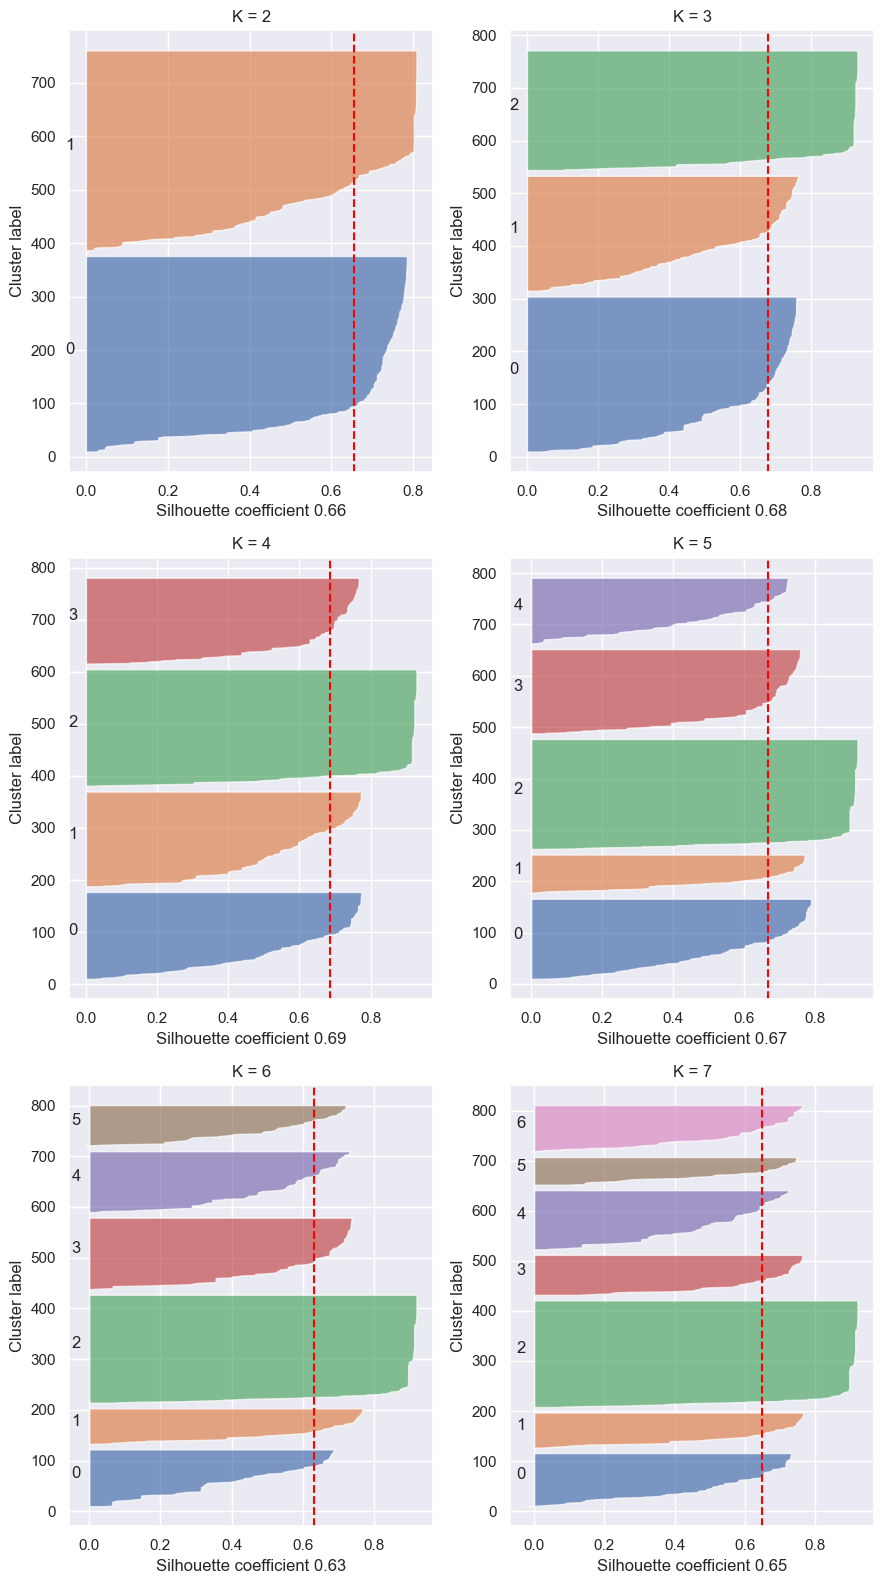

In [11]:
n_clusters_max = 8
fig, ax = plt.subplots(3, 2, figsize=(9, 16))

ax = ax.flatten()
labels_lst = []
silhoutte_scores = []
kmean_feature_norm_pca = {}

for n_clusters in range(2, n_clusters_max):
    labels = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(pre_processed_dataset_pca)
    labels_lst.append(labels)
    kmean_feature_norm_pca.update({f'K{n_clusters}': labels})
    silhoutte_scores.append(plot_silhoutte(pre_processed_dataset_pca, labels, n_clusters, ax[n_clusters - 2]))

In [12]:
with open('./data/kmeans_pca.jak', 'wb') as outp:  # Overwrites any existing file.
    pickle.dump(kmean_feature_norm_pca, outp)

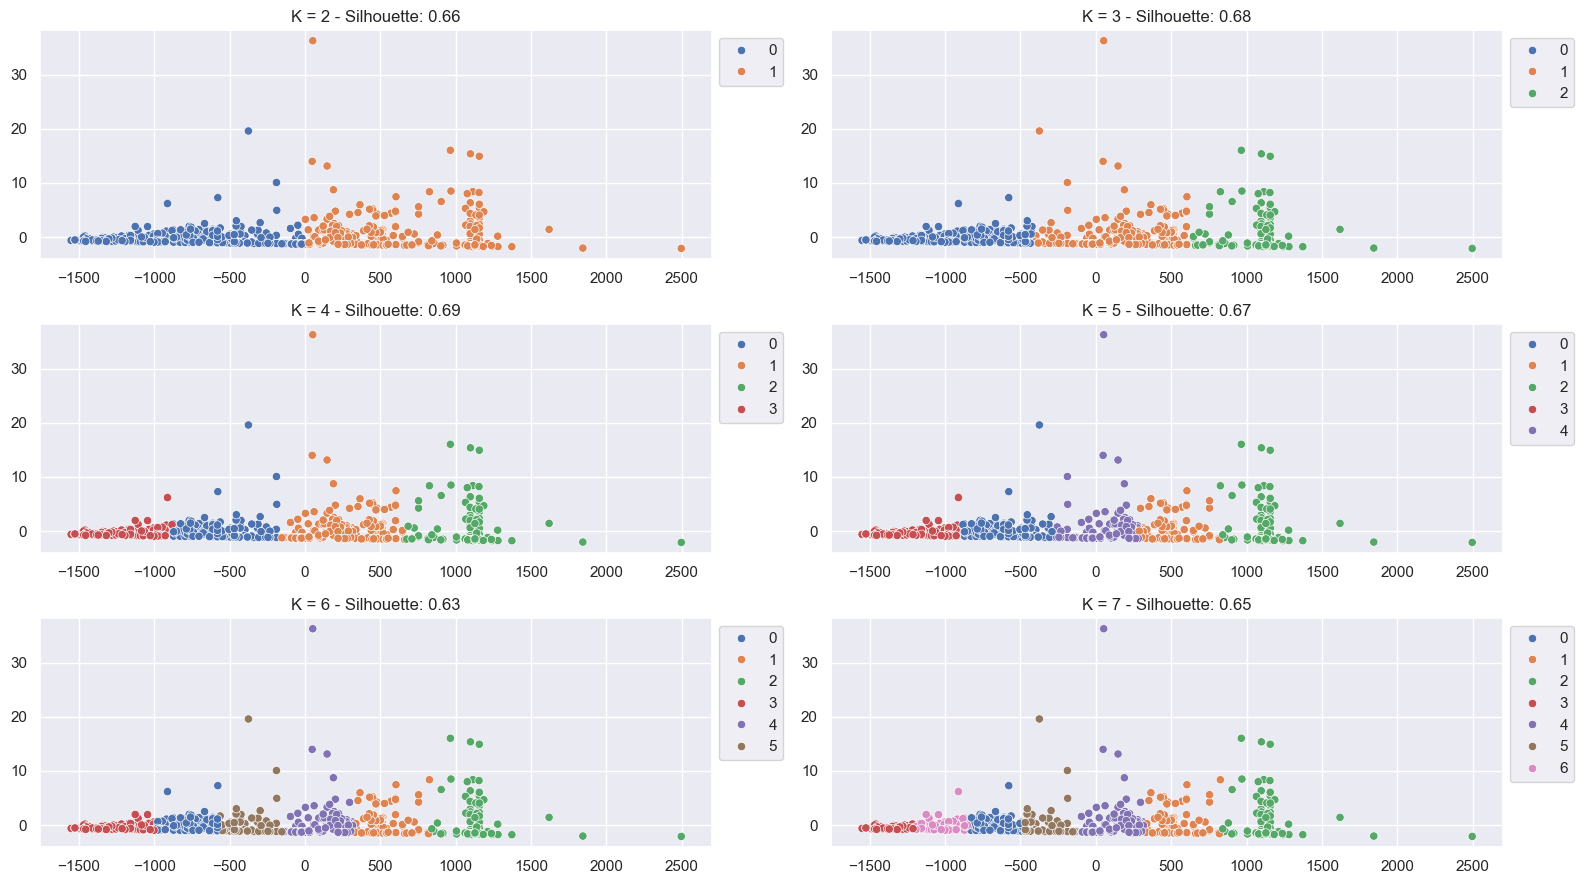

In [13]:
vis_clusters(labels_lst, pre_processed_dataset_pca, np.round(silhoutte_scores, 2))

## K Means and Kernel PCA

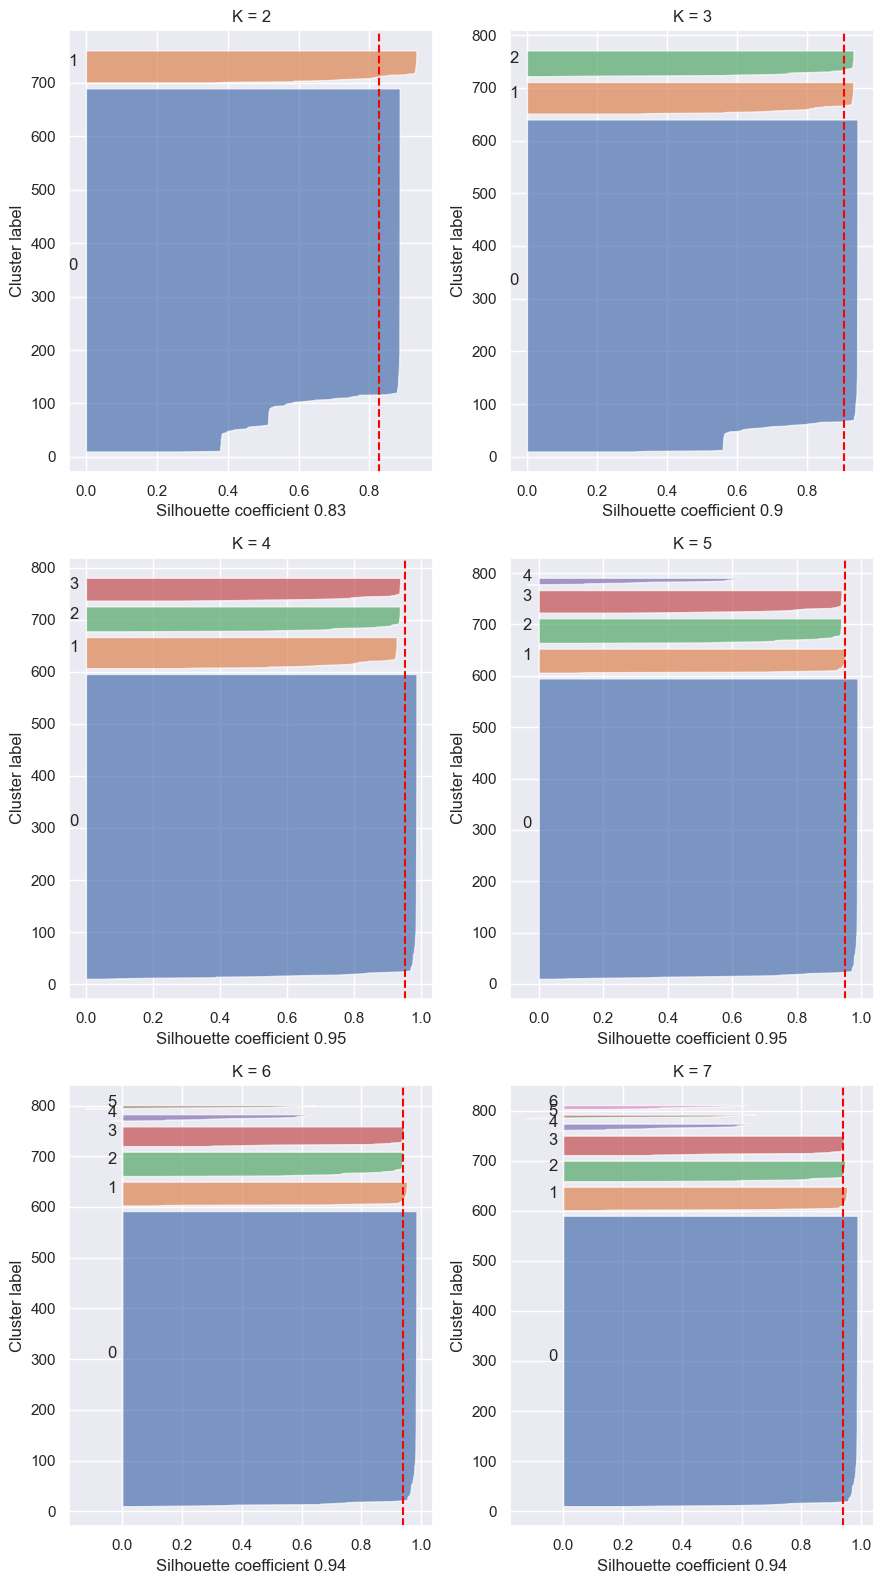

In [14]:
n_clusters_max = 8
fig, ax = plt.subplots(3, 2, figsize=(9, 16))

ax = ax.flatten()

labels_lst = []
silhoutte_scores = []

for n_clusters in range(2, n_clusters_max):
    labels = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(pre_processed_dataset_kpca)
    labels_lst.append(labels)
    
    silhoutte_scores.append(plot_silhoutte(pre_processed_dataset_kpca, labels, n_clusters, ax[n_clusters - 2]))

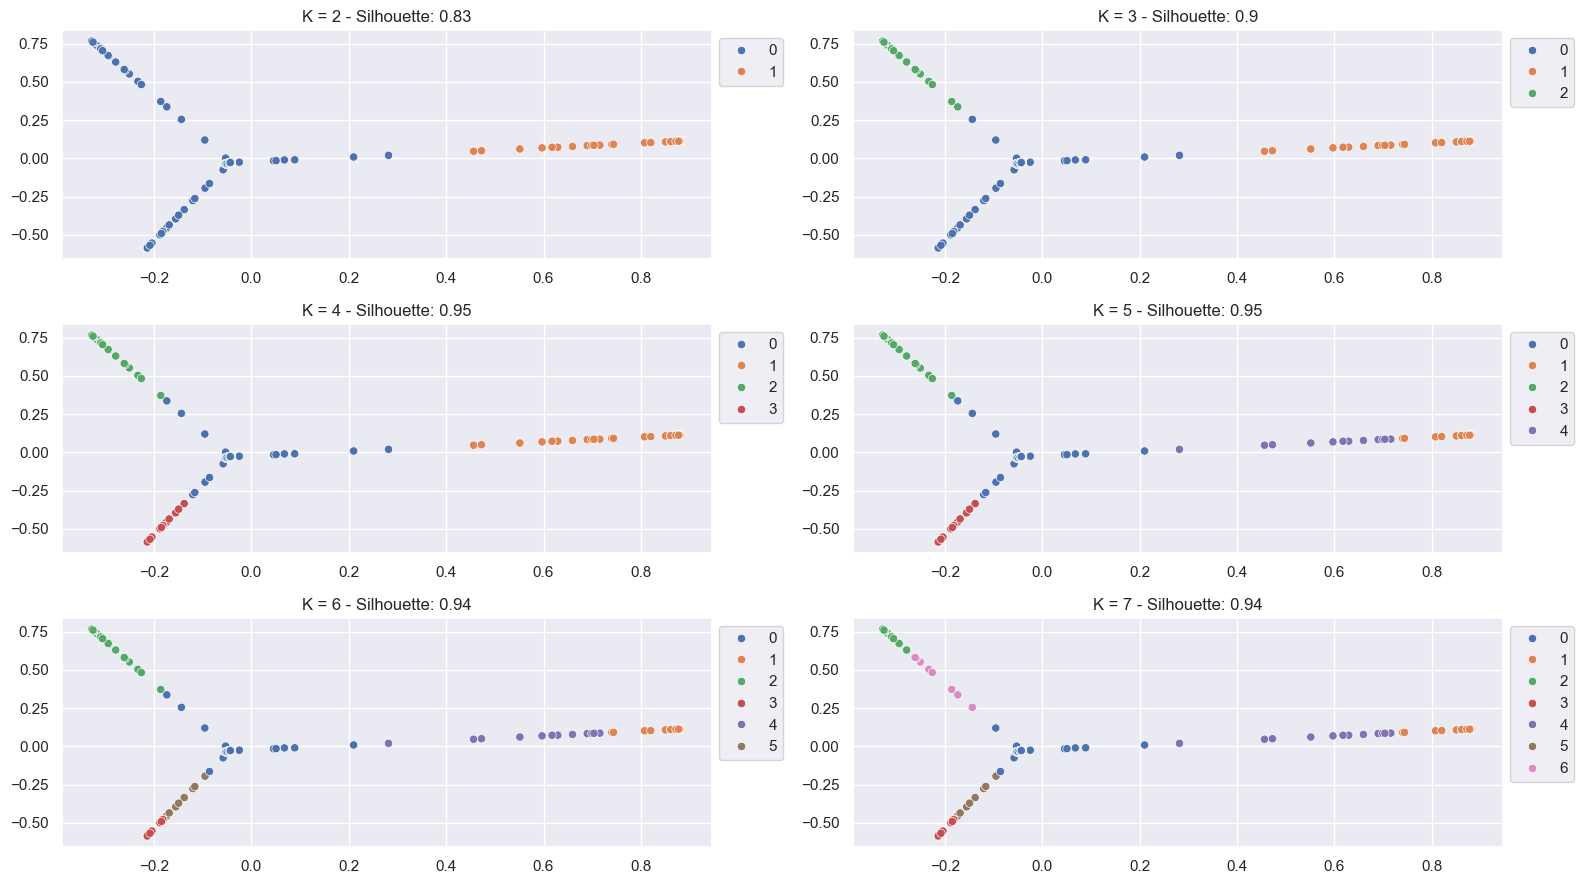

In [15]:
vis_clusters(labels_lst, pre_processed_dataset_kpca, np.round(silhoutte_scores, 2))

## Agglomerative single linkage full dataset

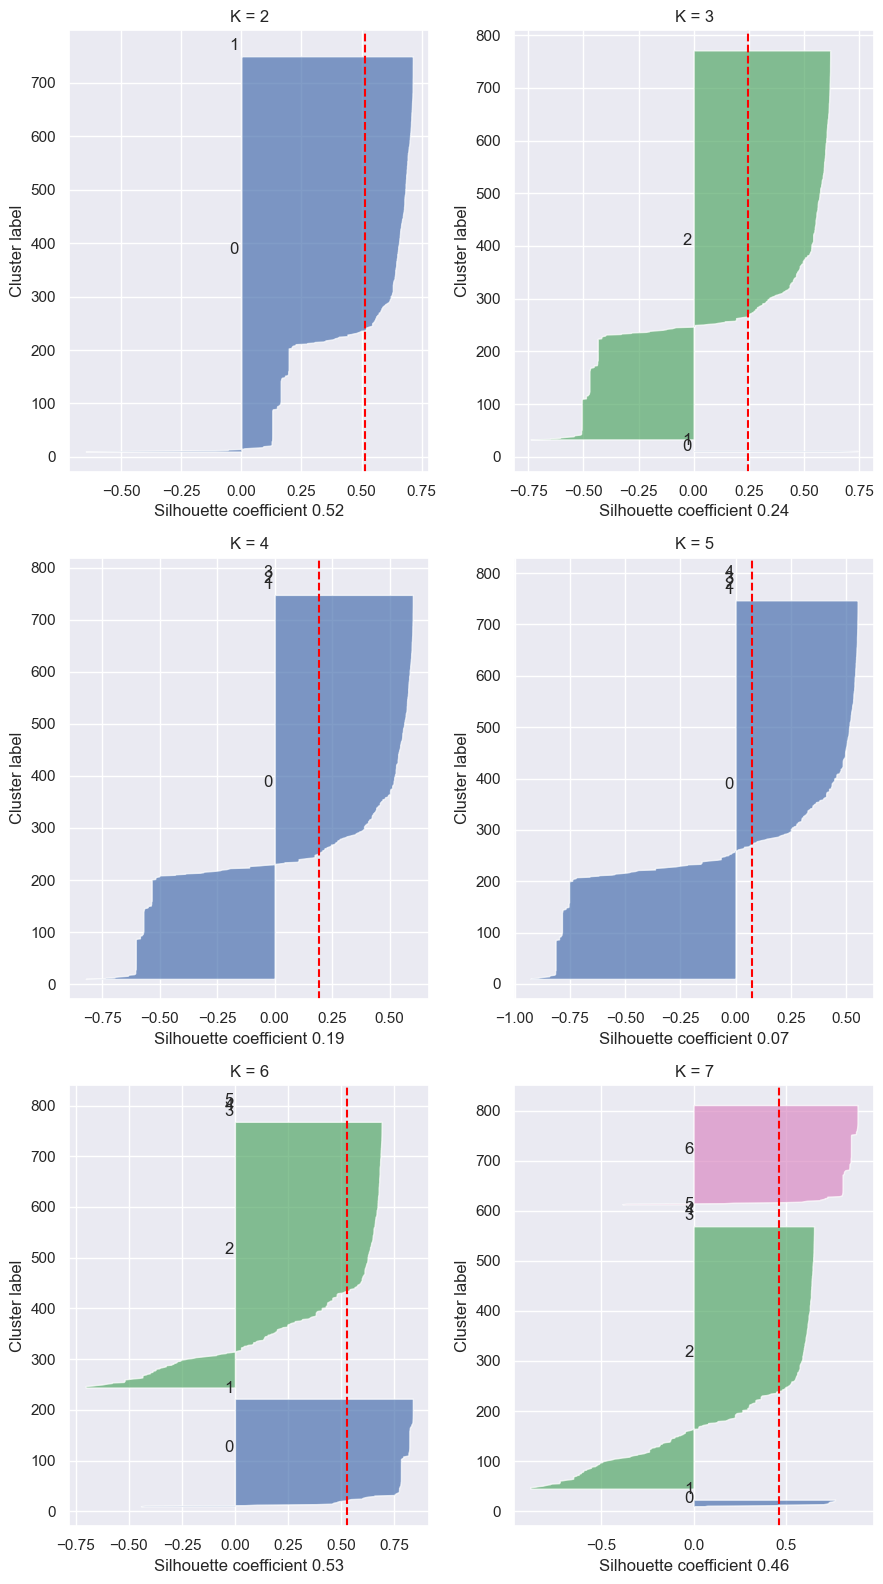

In [16]:
n_clusters_max = 8
fig, ax = plt.subplots(3, 2, figsize=(9, 16))

ax = ax.flatten()


for n_clusters in range(2, n_clusters_max):
    labels = AgglomerativeClustering(n_clusters=n_clusters, linkage='single').fit_predict(pre_processed_dataset_no_dim)
    
    plot_silhoutte(pre_processed_dataset_no_dim, labels, n_clusters, ax[n_clusters - 2])

## Agglomerative single linkage after normalization and pca

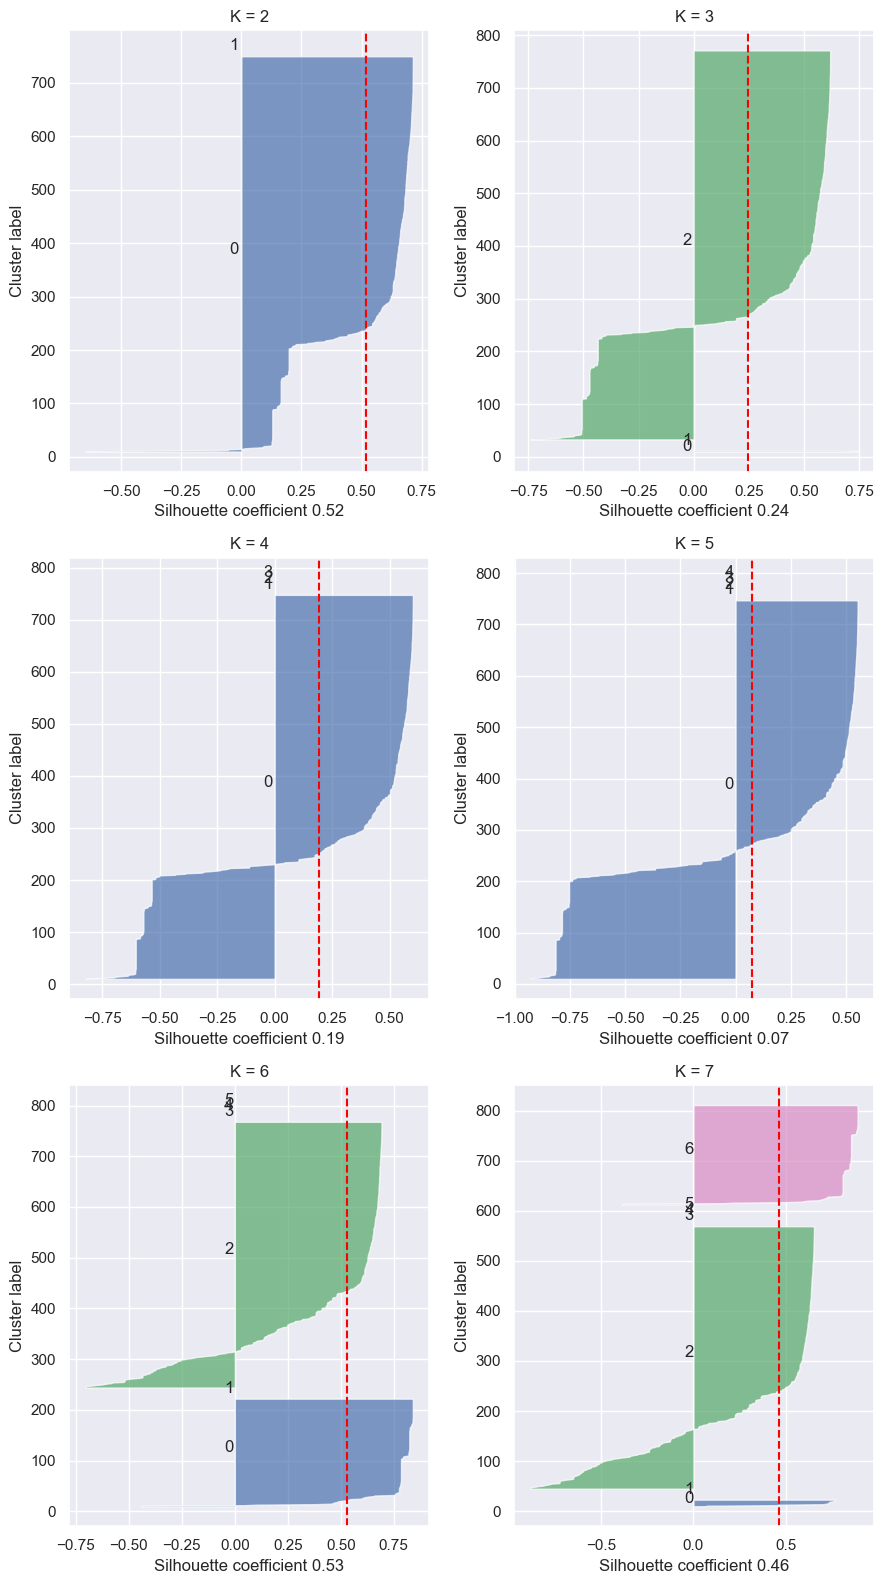

In [17]:
n_clusters_max = 8
fig, ax = plt.subplots(3, 2, figsize=(9, 16))

ax = ax.flatten()

labels_lst = []
silhoutte_scores = []

for n_clusters in range(2, n_clusters_max):
    labels = AgglomerativeClustering(n_clusters=n_clusters, linkage='single').fit_predict(pre_processed_dataset_pca)
    labels_lst.append(labels)
    
    silhoutte_scores.append(plot_silhoutte(pre_processed_dataset_pca, labels, n_clusters, ax[n_clusters - 2]))

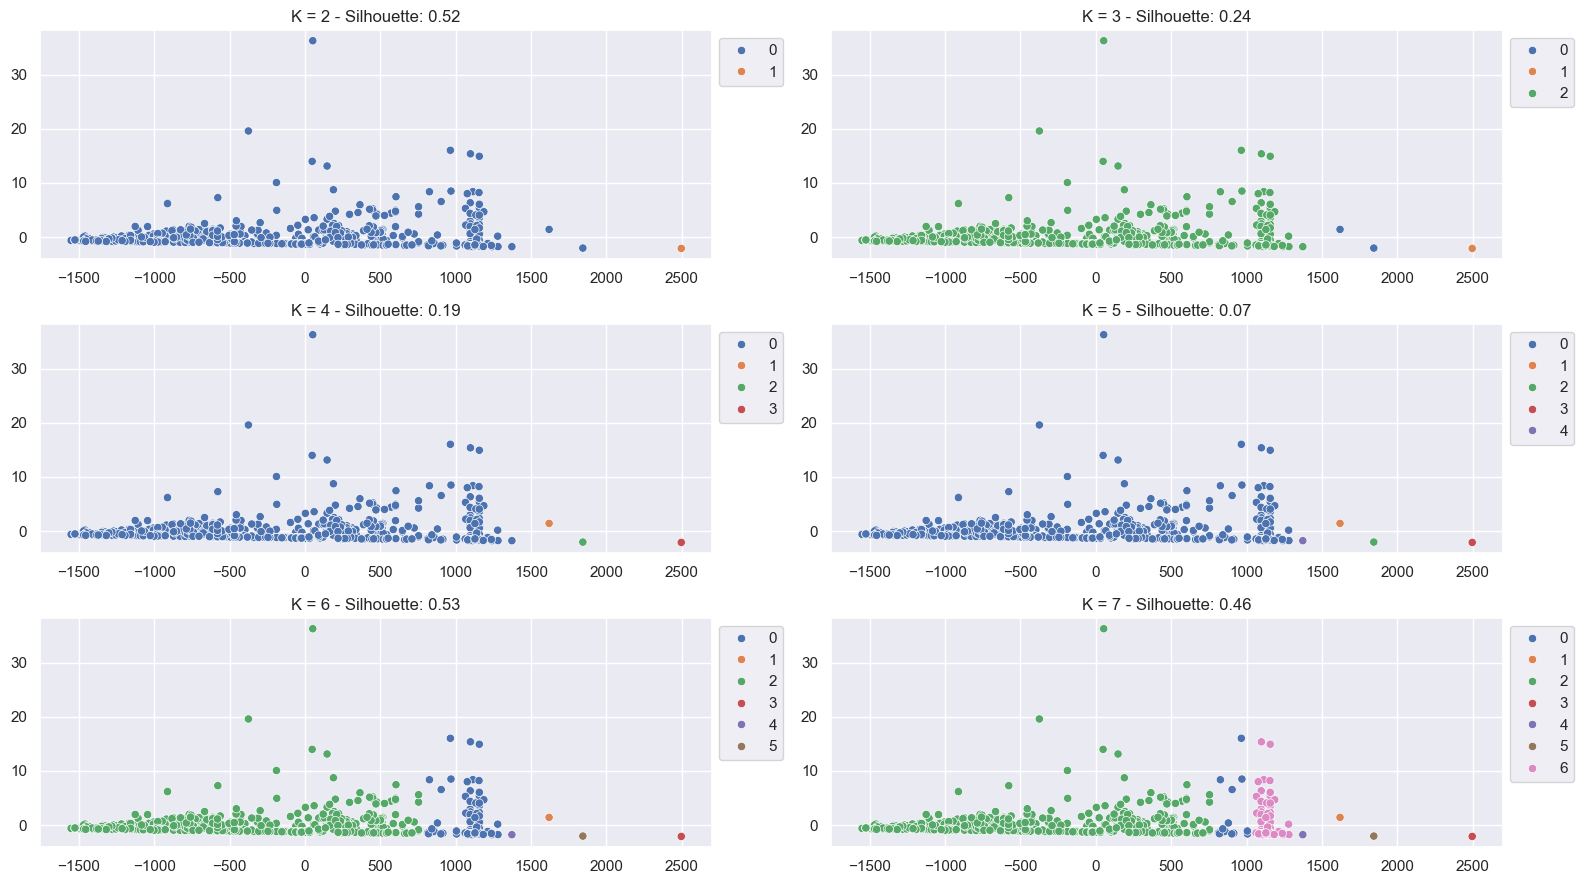

In [18]:
vis_clusters(labels_lst, pre_processed_dataset_pca, np.round(silhoutte_scores, 2))

## Agglomerative single linkage with normalization and KernelPCA

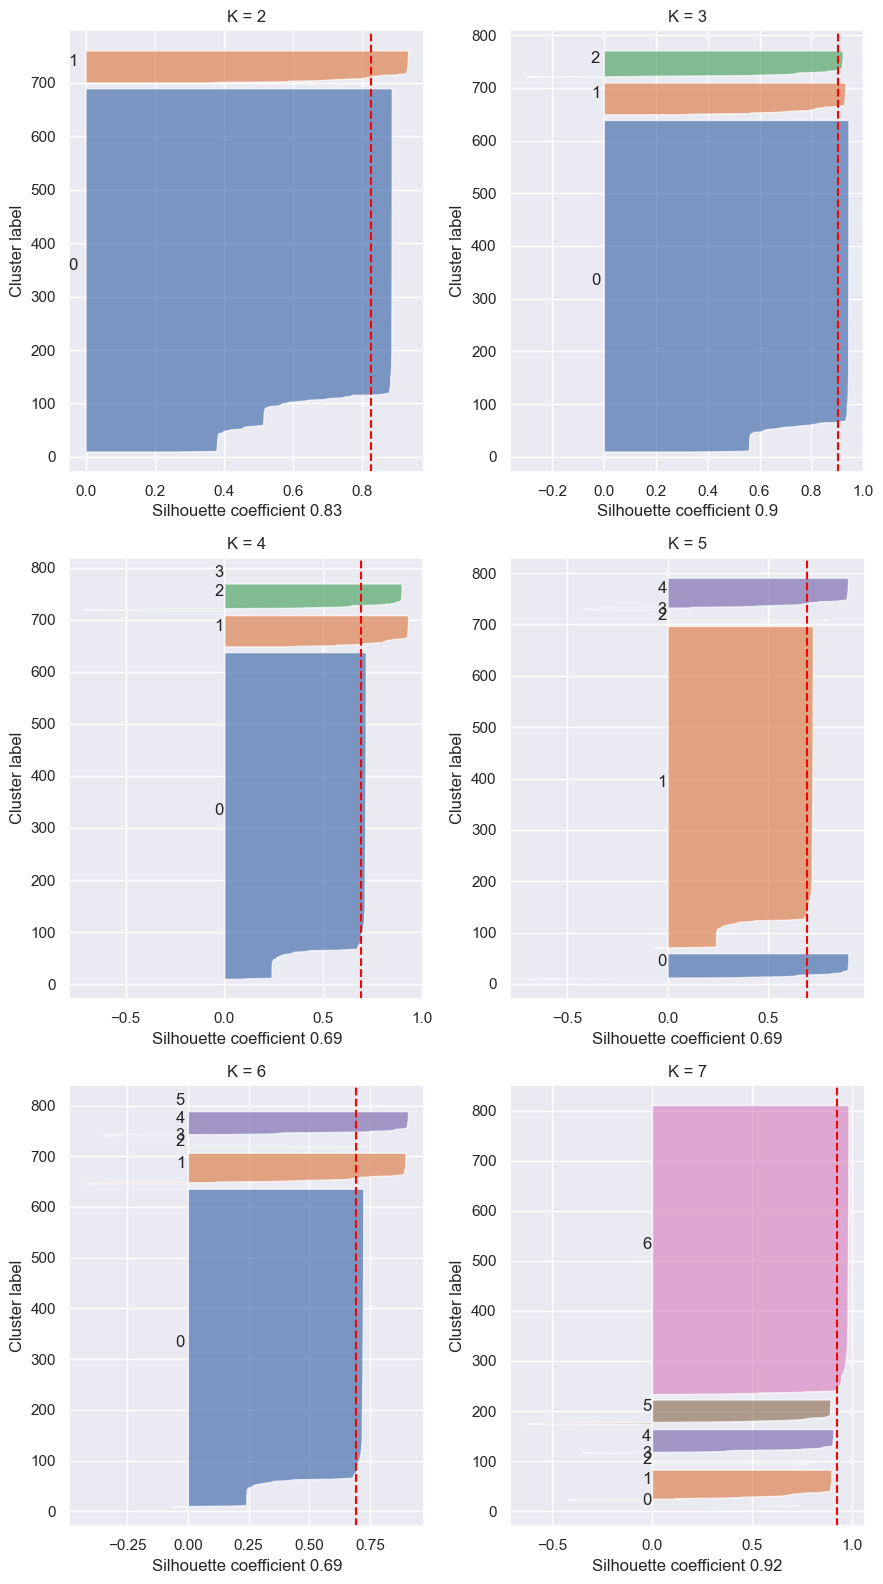

In [19]:
n_clusters_max = 8
fig, ax = plt.subplots(3, 2, figsize=(9, 16))

ax = ax.flatten()

labels_lst = []
silhoutte_scores = []

for n_clusters in range(2, n_clusters_max):
    labels = AgglomerativeClustering(n_clusters=n_clusters, linkage='single').fit_predict(pre_processed_dataset_kpca)
    labels_lst.append(labels)
    
    silhoutte_scores.append(plot_silhoutte(pre_processed_dataset_kpca, labels, n_clusters, ax[n_clusters - 2]))

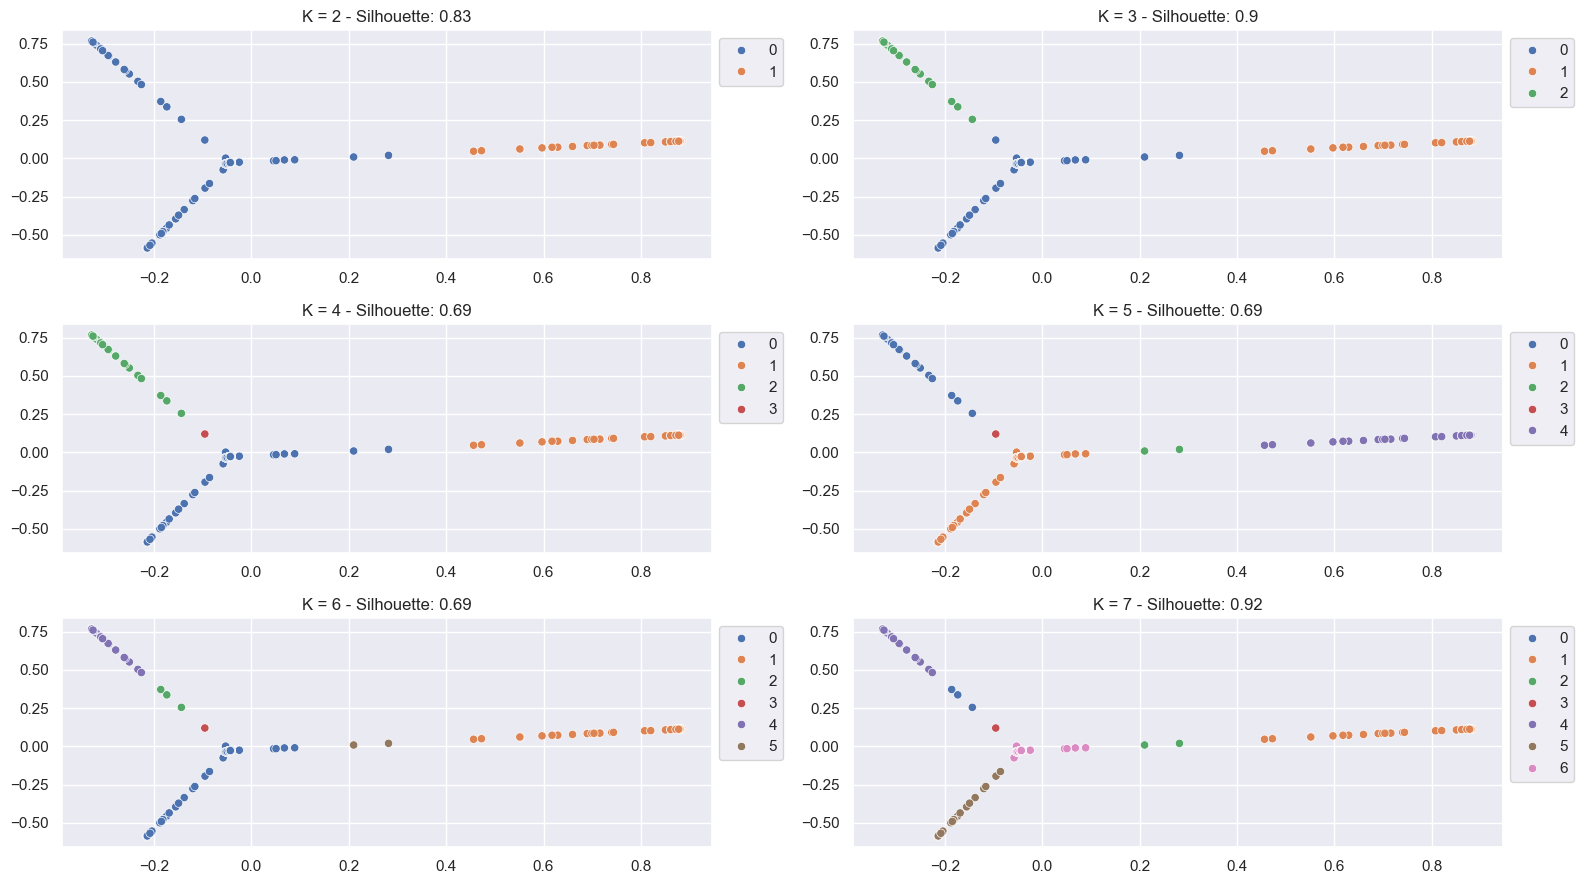

In [20]:
vis_clusters(labels_lst, pre_processed_dataset_kpca, np.round(silhoutte_scores, 2))

## Agglomerative ward linkage full dataset

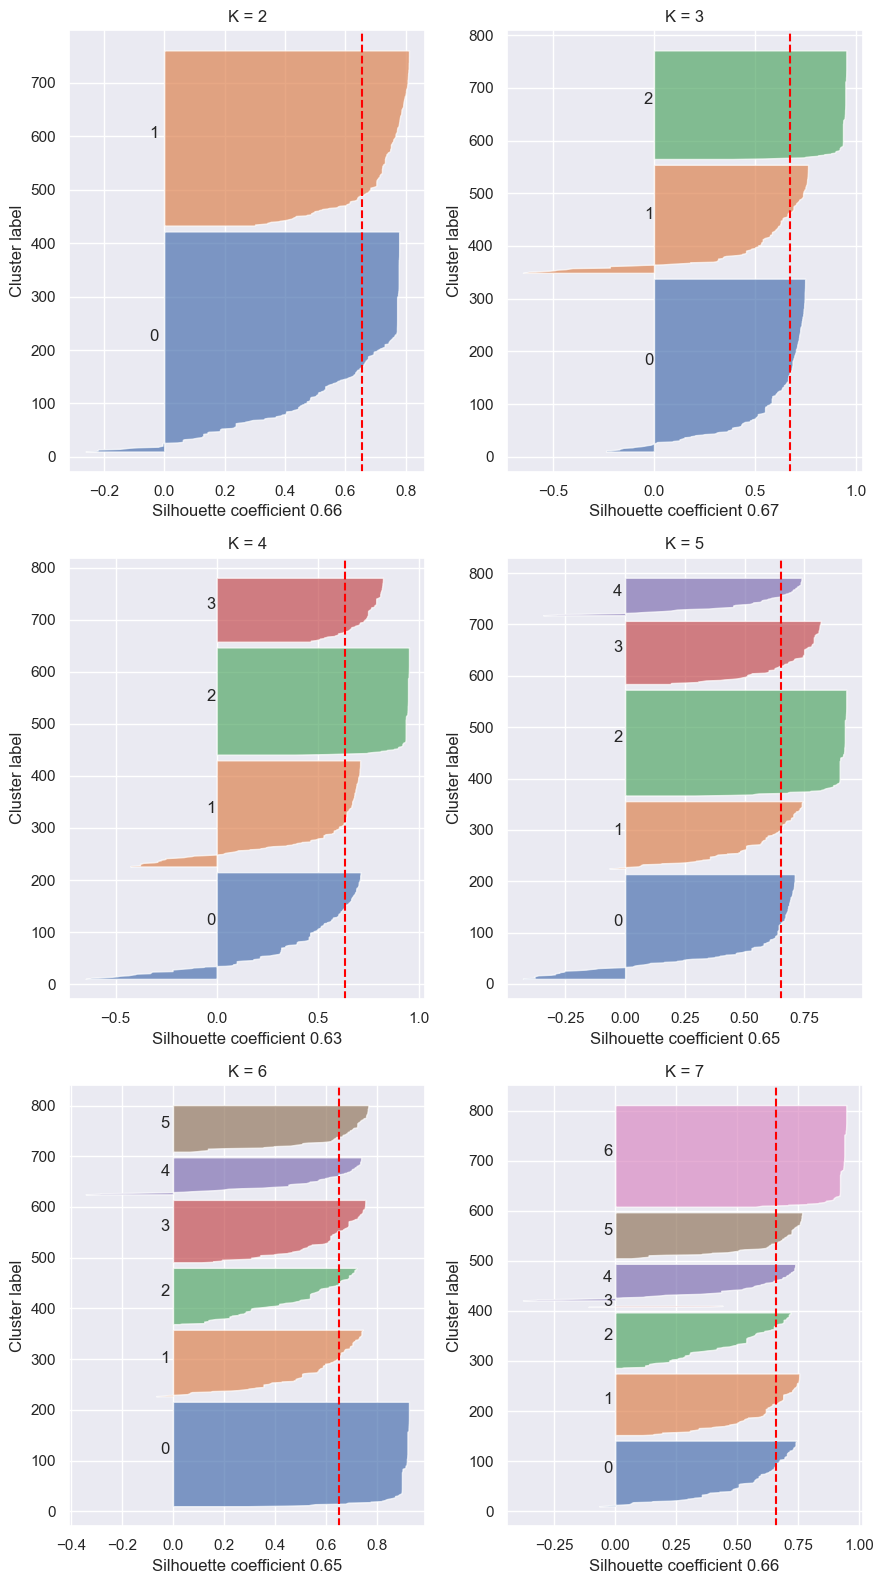

In [21]:
n_clusters_max = 8
fig, ax = plt.subplots(3, 2, figsize=(9, 16))

ax = ax.flatten()

for n_clusters in range(2, n_clusters_max):
    labels = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit_predict(pre_processed_dataset_no_dim)
    
    plot_silhoutte(pre_processed_dataset_no_dim, labels, n_clusters, ax[n_clusters - 2])

## Agglomerative ward linkage with normalization and PCA

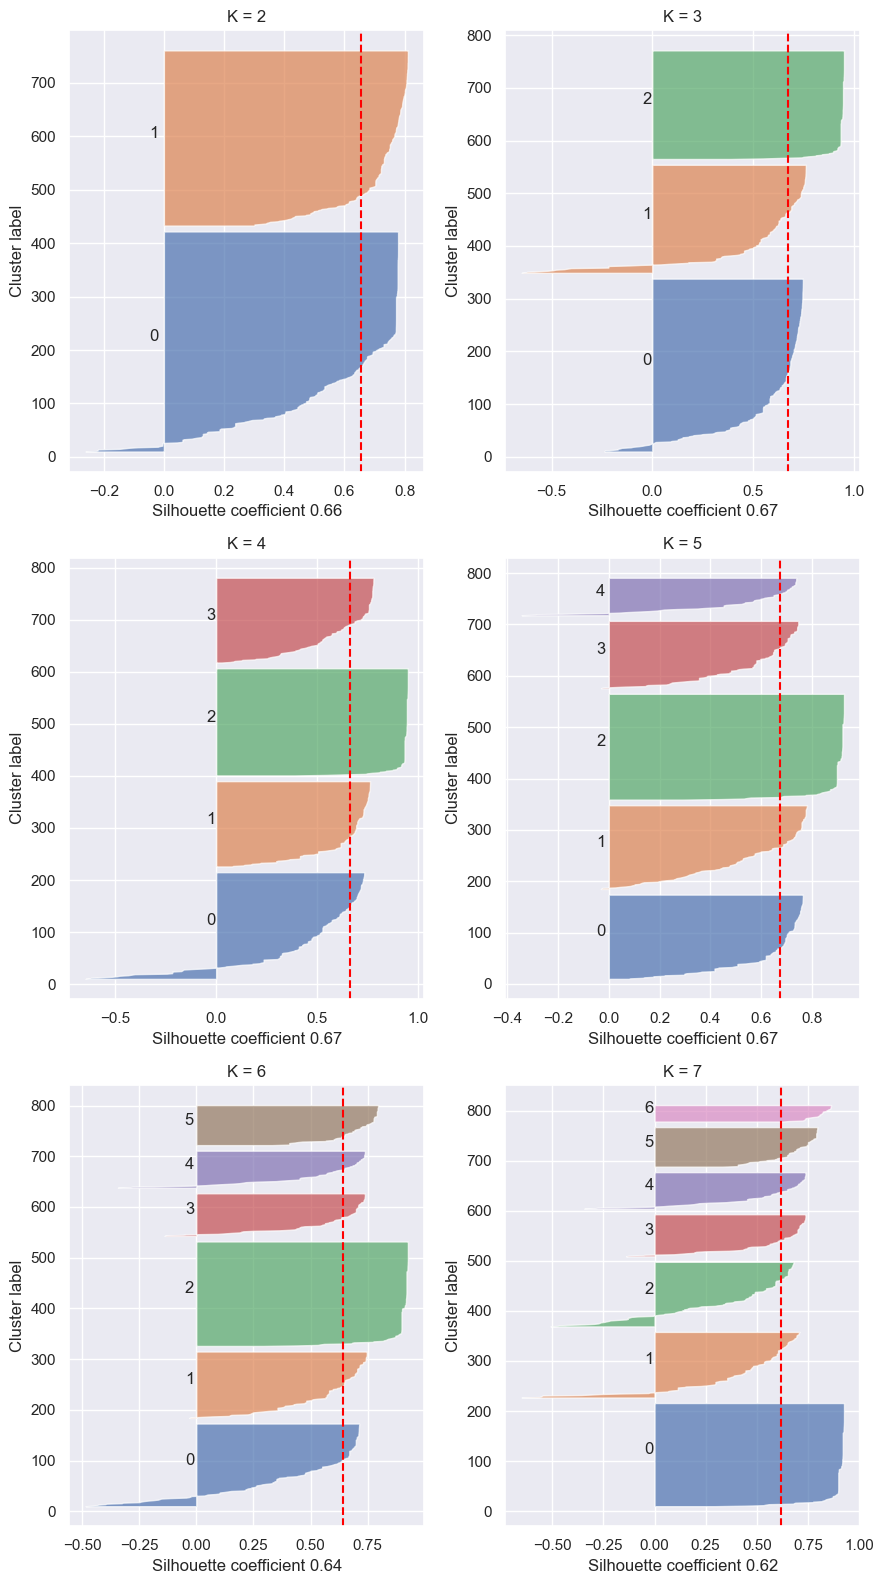

In [22]:
n_clusters_max = 8
fig, ax = plt.subplots(3, 2, figsize=(9, 16))

ax = ax.flatten()

labels_lst = []
silhoutte_scores = []

for n_clusters in range(2, n_clusters_max):
    labels = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit_predict(pre_processed_dataset_pca)
    labels_lst.append(labels)
    
    silhoutte_scores.append(plot_silhoutte(pre_processed_dataset_pca, labels, n_clusters, ax[n_clusters - 2]))

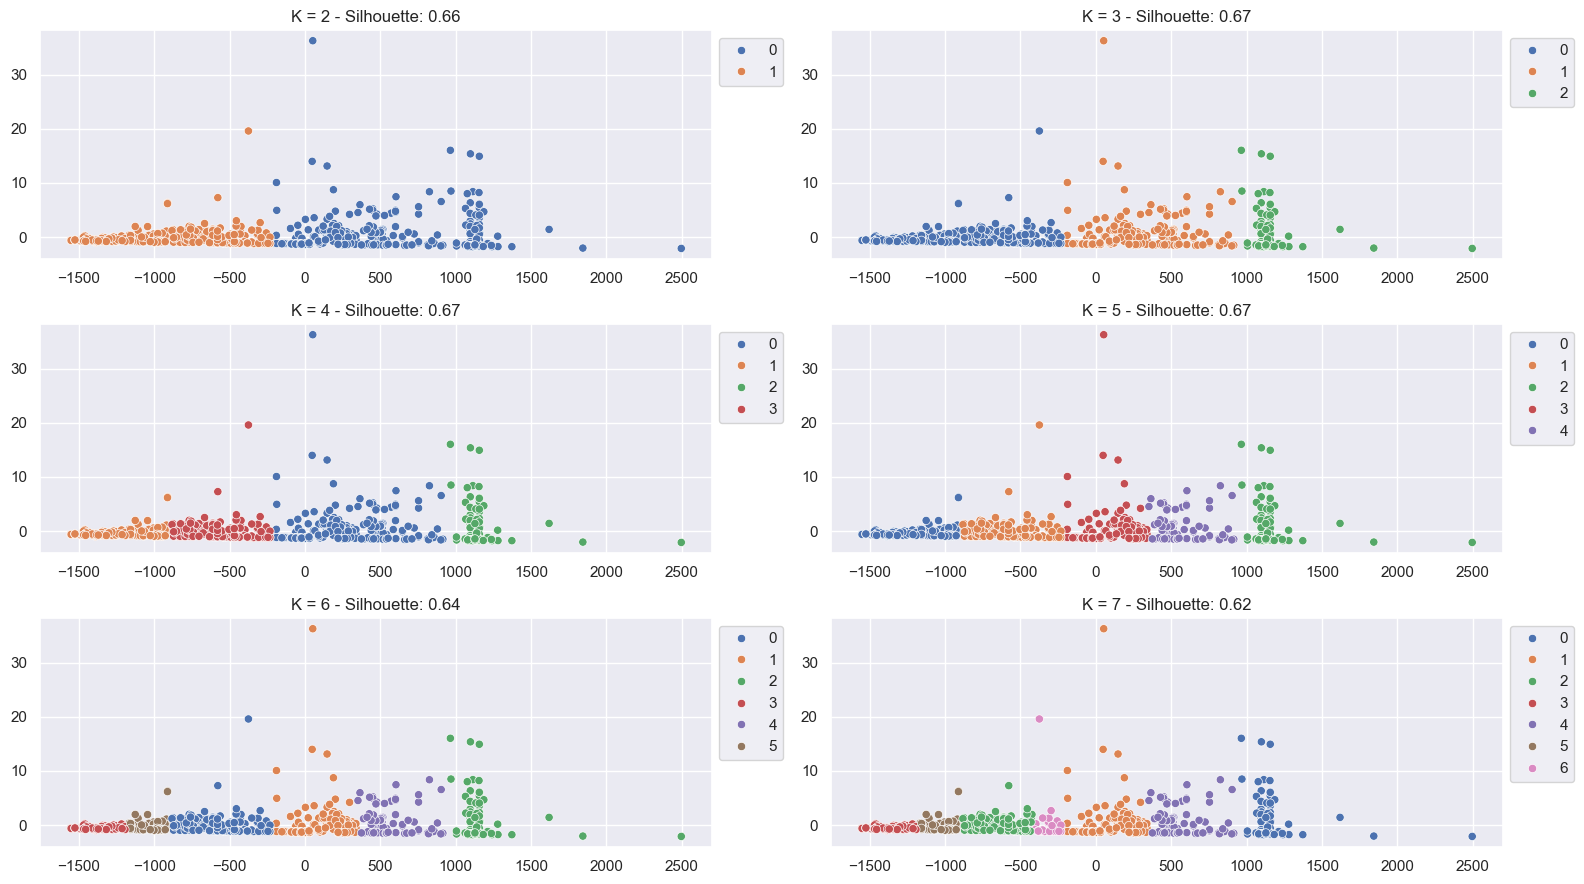

In [23]:
vis_clusters(labels_lst, pre_processed_dataset_pca, np.round(silhoutte_scores, 2))

## Agglomerative ward linkage with normalization and KernelPCA

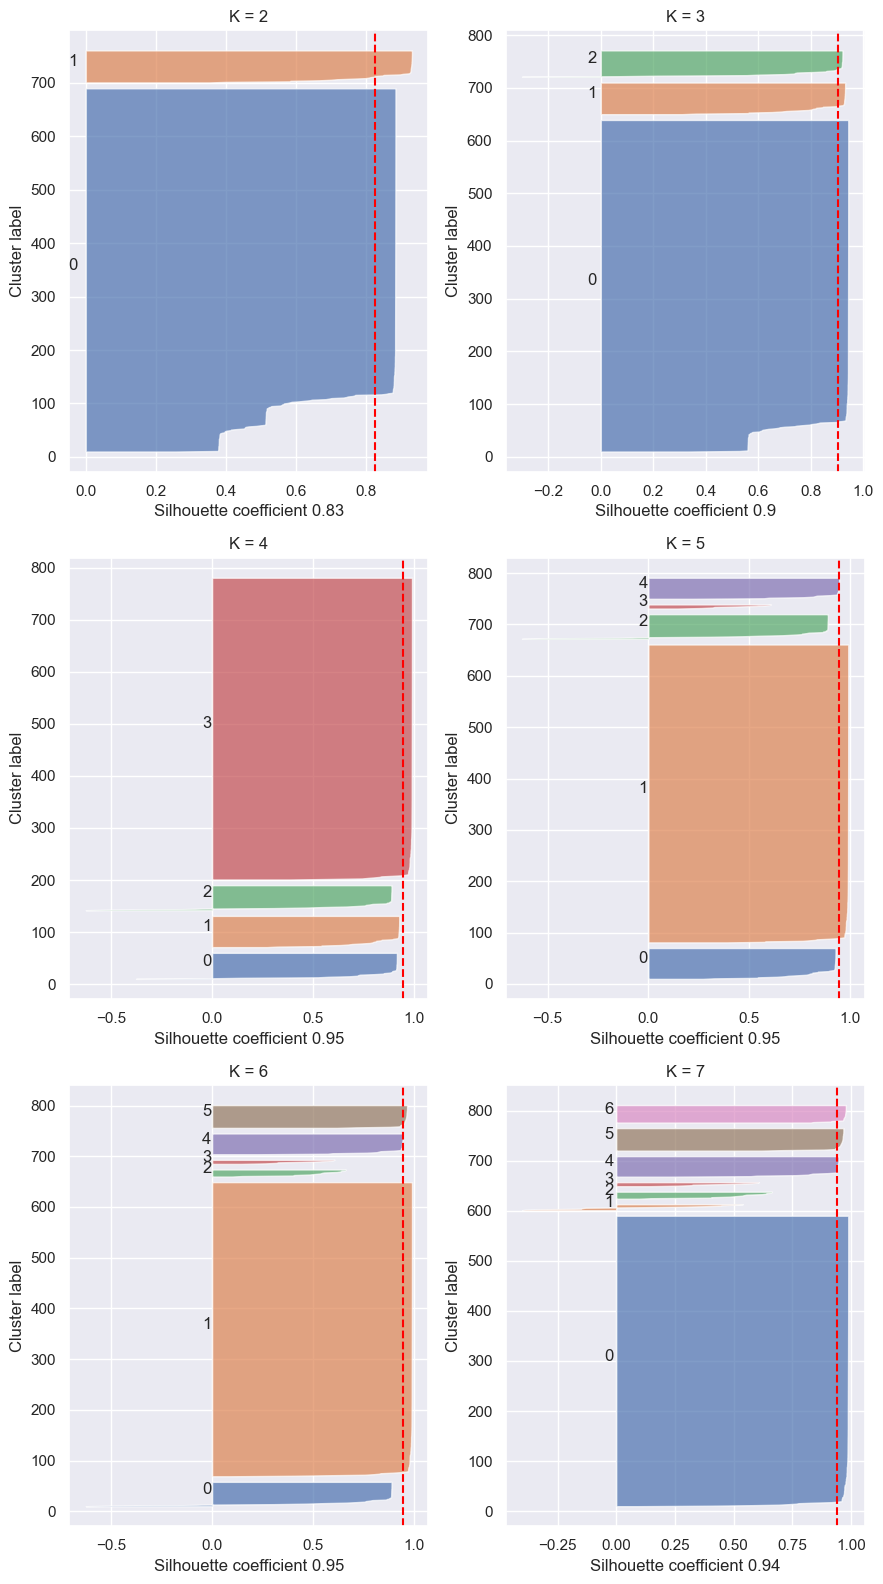

In [24]:
n_clusters_max = 8
fig, ax = plt.subplots(3, 2, figsize=(9, 16))

ax = ax.flatten()

labels_lst = []
silhoutte_scores = []
agg_ward_kpca = {}

for n_clusters in range(2, n_clusters_max):
    labels = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit_predict(pre_processed_dataset_kpca)
    labels_lst.append(labels)
    agg_ward_kpca.update({f'K{n_clusters}': labels})

    silhoutte_scores.append(plot_silhoutte(pre_processed_dataset_kpca, labels, n_clusters, ax[n_clusters - 2]))

In [25]:
with open('./data/agg_ward_kpca.jak', 'wb') as outp:  # Overwrites any existing file.
    pickle.dump(agg_ward_kpca, outp)

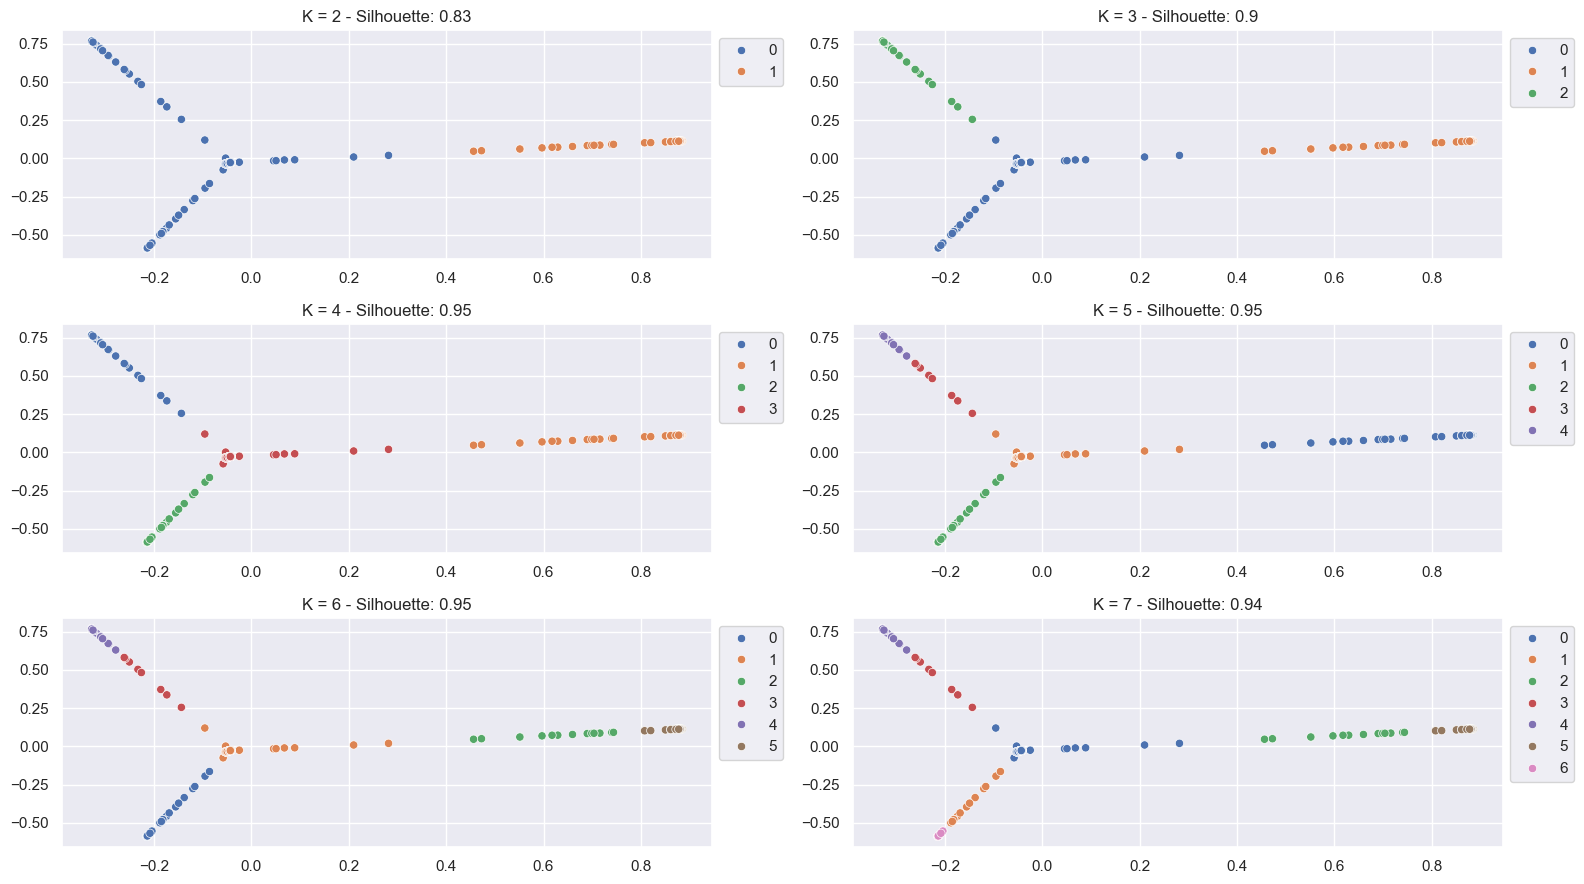

In [26]:
vis_clusters(labels_lst, pre_processed_dataset_kpca, np.round(silhoutte_scores, 2))

Let's see a 3D plot for K=4:

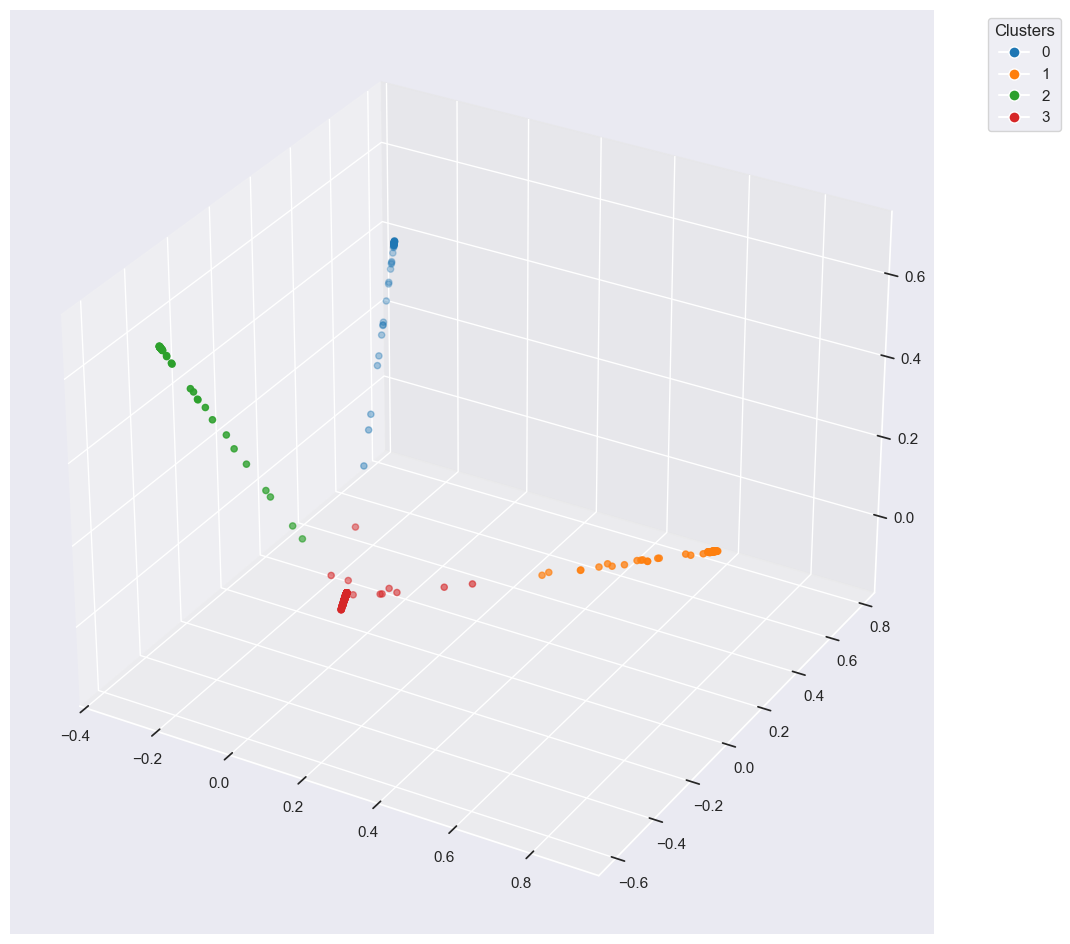

In [27]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

sequence_containing_x_vals = pre_processed_dataset_3kpca[:, 0]
sequence_containing_y_vals = pre_processed_dataset_3kpca[:, 1]
sequence_containing_z_vals = pre_processed_dataset_3kpca[:, 2]

colors = {0:'tab:blue', 1:'tab:orange', 2:'tab:green', 3:'tab:red'}

handles = [
    plt.Line2D([0], [0], 
               marker='o', 
               color='w', 
               markerfacecolor=v, 
               label=k, 
               markersize=8
    ) 
    for k, v in colors.items()
]

ax.scatter(
    sequence_containing_x_vals, 
    sequence_containing_y_vals, 
    sequence_containing_z_vals, 
    c=pd.Series(labels_lst[2]).map(colors),
    label=set(labels_lst[2]),
);

ax.legend(title='Clusters', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left');

## Trying Dbscan with kernel PCA

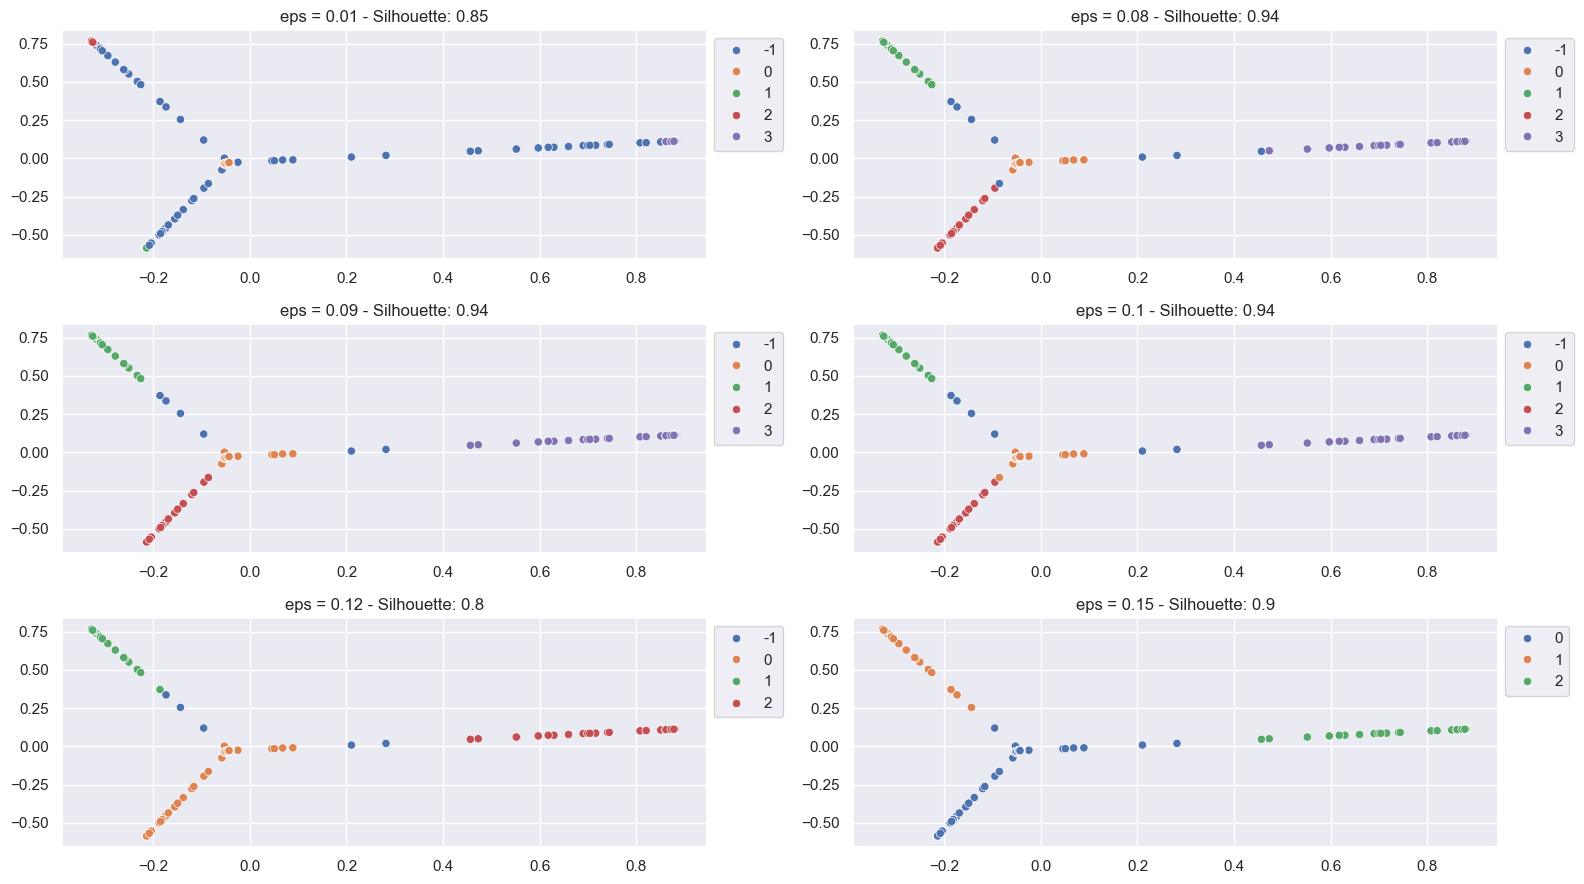

In [28]:
labels_lst = []
silhoutte_scores = []
eps_lst = [0.01, 0.08, 0.09, 0.10, 0.12, 0.15]

for eps in eps_lst:
    labels_lst.append(DBSCAN(eps=eps, min_samples=4).fit_predict(pre_processed_dataset_kpca))
    silhoutte_scores.append(silhouette_score(pre_processed_dataset_kpca, labels_lst[-1]))

vis_clusters(labels_lst, pre_processed_dataset_kpca, np.round(silhoutte_scores, 2), eps=eps_lst)

In [29]:
with open('./data/dbscan_kpca.jak', 'wb') as outp:  # Overwrites any existing file.
    pickle.dump({'eps0.9': labels_lst[2]}, outp)

### Comments

- Since PCA explains most of the variance, applying K Means and agglomerative clustering on the reduced dataset and on the full one does not change results;
- Using KernelPCA with an RBF kernel seems to provide a good separations of data points that makes clustering easier for K-Means and Agglomerative;
- PCA looks as though it does not really capture different clusters. The distributions of points looks really dense and "flat";
- Agglomerative clustering with single linkage performes awfully, due to the presence of outliers;
- Agglomerative clustering with ward linkage seems more stable and provides good results with the kernel pca pipeline.
- Observing data points' plots and cosindering K=4, Ward clustering provides less mixing than 4-Means using the kernel pca approach, even though the silhoutte score for K = 4 is the the same in both K-Means and Ward the latter;
    - *Silhoutte coefficient is an intuitive internal validation criteria, but like every other methods of the same category, is not good to compare different algorithms, since results will be biased towards a particular one. At least the absolute values gives some insights. But in this case for example a visual analysis were required to discriminate the best tecnique.*
- Applying DBSCAN on the kernel pca dataset, provides good results in terms of both silhoutte score and seprations. In particular with eps = 0.09. The advantage in using this tecnique is the fact that noise points are detected automatically. Since no outlier are removed, this property is really useful.

In order to understand results the association analysis will be performed (internally at each cluster) on the following results:
1. 3-Means with PCA;
2. Agglomerativa word linkage with Kernel PCA (K = 2 and K = 4)
3. DBSCAN (eps = 0.09)